# Time series Forecasting

In [24]:
import seaborn as sns
import numpy as np

data = sns.load_dataset("flights")
month_map = {month: i for i, month in enumerate(data["month"].cat.categories, start=1)}
data["month"] = data["month"].map(month_map)
data.head()

,year,month,passengers
0,1949,1,112
1,1949,2,118
2,1949,3,132
3,1949,4,129
4,1949,5,121


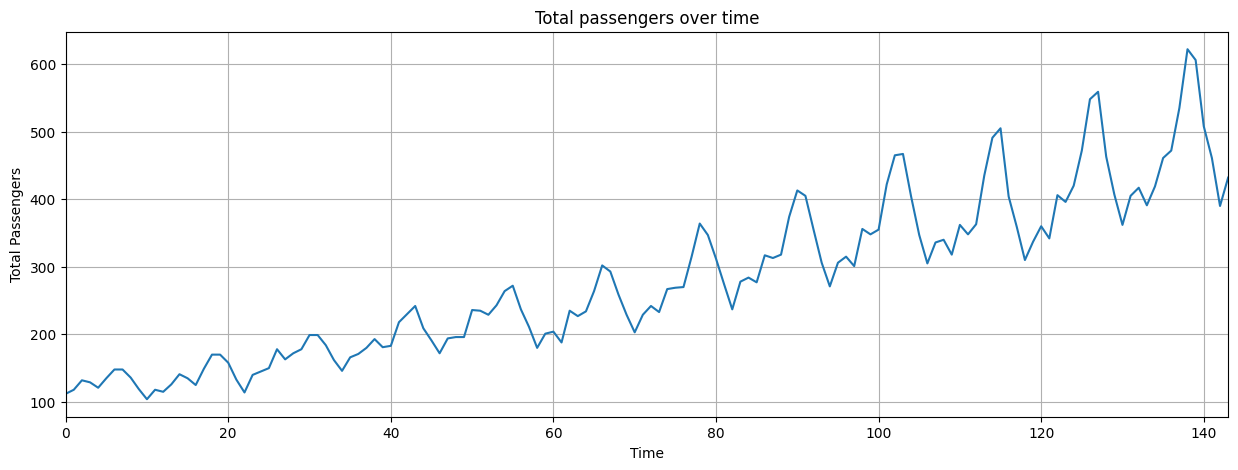

In [86]:
import matplotlib.pyplot as plt

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Total passengers over time')
plt.ylabel('Total Passengers')
plt.xlabel('Time')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(data['passengers'])
plt.show()

In [94]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

SEQ_LENGTH = 3  # Size sequence
PREDICT_AHEAD = 1 # Forecast horizon
explanatory_variables = ['month', 'year']
target = "passengers"
scaler = MinMaxScaler()

# train-test split for time series
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[:train_size], data[train_size:]

train[explanatory_variables+[target]] = scaler.fit_transform(train[explanatory_variables+[target]])
test[explanatory_variables+[target]] = scaler.transform(test[explanatory_variables+[target]])

class TimeSeriesDataset(Dataset):
    def __init__(self, df, seq_length, predict_ahead):
        self.df = df
        self.seq_length = seq_length
        self.predict_ahead = predict_ahead

    def __len__(self):
        return len(self.df) - self.seq_length - self.predict_ahead

    def __getitem__(self, index):
        past_data = self.df.iloc[index : index + self.seq_length][explanatory_variables+[target]].values
        future_y = self.df.iloc[index + self.seq_length + self.predict_ahead][target]

        past_data[-self.predict_ahead:, 0] = 0  # Mask y(t-1 to t)

        return torch.tensor(past_data, dtype=torch.float32), torch.tensor(future_y, dtype=torch.float32)
    
    def denormalize(self, y):
        df = pd.DataFrame(index=self.df.index)
        df = df.iloc[self.seq_length + self.predict_ahead:]
        df['Pred'] = y*(scaler.data_max_[-1] - scaler.data_min_[0]) + scaler.data_min_[-1]
        return df

train_set = TimeSeriesDataset(train, SEQ_LENGTH, PREDICT_AHEAD)
test_set = TimeSeriesDataset(test, SEQ_LENGTH, PREDICT_AHEAD)

train_loader = DataLoader(train_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)


print(f"X: {train_set.__getitem__(0)[0].shape}, y: {test_set.__getitem__(0)[1]}")

X: torch.Size([3, 3]), y: 0.8122977614402771


/tmp/ipykernel_29773/950504395.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[explanatory_variables+[target]] = scaler.fit_transform(train[explanatory_variables+[target]])
/tmp/ipykernel_29773/950504395.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[explanatory_variables+[target]] = scaler.transform(test[explanatory_variables+[target]])


In [95]:
import torch.nn as nn
import os

class TimeSeriesModel(nn.Module):
    def __init__(self, args, ts_shape):
        super().__init__()
        self.args = args
        self.input_shape = ts_shape

        # 1-dimensional DAG
        self.cell_1d = args['1D Dag']
        self.cell_1d.set(self.input_shape)

        self.flat_shape = (1, np.prod(self.cell_1d.output_shape))
        # Output layer
        self.output = args["Out"]
        args['Out'].set(self.flat_shape)

    def forward(self, X, h=None):
        out_1d = self.cell_1d(X)
        if isinstance(out_1d, tuple):
            out_1d, h = out_1d
        else: 
            h = None
        flat = nn.Flatten(start_dim=1)(out_1d).unsqueeze(1)
        out = self.output(flat)
        if h is not None:
            return out.squeeze(-1).squeeze(-1), h
        else: return out.squeeze(-1).squeeze(-1)

    def set_prediction_to_save(self, name, df):
        self.prediction = {name: df}

    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        full_path = os.path.join(path, "best_model.pth")
        torch.save(self.state_dict(), full_path)
        if hasattr(self, "prediction"):
            for k in self.prediction.keys():
                self.prediction[k].to_csv(os.path.join(path, f"best_model_{k}_outputs.csv"))

In [96]:
from dragon.search_operators.base_neighborhoods import ArrayInterval, FloatInterval
from dragon.search_space.base_variables import ArrayVar, FloatVar
from dragon.search_space.bricks_variables import attention_1d, dag_var, identity_var, mlp_const_var, node_var, operations_var, recurrence_1d
from dragon.search_space.bricks_variables import mlp_var, conv_1d, pooling_1d, norm_1d, dropout

candidate_operations_1d = operations_var("2D Candidate operations", size=5,
                                            candidates=[identity_var("Unitary"), attention_1d("Attention"), mlp_var("MLP"), conv_1d("conv 1d", max_out=3, permute=False),
                                                        recurrence_1d("rnn_1d"), pooling_1d('Pooling'), norm_1d("Norm"), dropout('Dropout')])
dag_1d = dag_var("1D Dag", candidate_operations_1d)
out = node_var("Out", operation=mlp_const_var('Operation', 1), activation_function=nn.Identity())
lr = FloatVar("LR", lower=0.001, upper=0.1, neighbor=FloatInterval(0.01))

search_space = ArrayVar(dag_1d, out, lr, label="Search Space", neighbor=ArrayInterval())
labels = [e.label for e in search_space]

In [97]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def MSE(actual, pred):
    return np.mean((actual - pred) ** 2)


def MAPE(actual, pred):
    return np.mean(np.abs((actual - pred) / actual))


def RMSE(actual, pred):
    return np.sqrt(MSE(actual, pred))

def train_model(model, data_loader, lr, verbose=False):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model.train()
    for ep in range(20):
        h = None
        ep_loss = 0
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            X, y = X.float(), y.float()
            pred = model(X, h)
            if isinstance(pred, tuple):
                pred, h = pred
                h = [hh.detach() for hh in h if hasattr(hh, "grad")]
            loss = loss_fn(pred,y)
            loss.backward()
            optimizer.step()
            ep_loss += loss
        if verbose:
            print(f"Train | Epoch: {ep}, loss = {ep_loss / len(data_loader)}")
    return model, h

def test_model(model, data_loader, h):
    loss_fn = nn.MSELoss()
    model.eval()
    test_loss = 0
    preds = []
    trues = []
    with torch.no_grad():
      for X, y in data_loader:
          X = X.to(device)
          y = y.to(device)
          X, y = X.float(), y.float()
          pred = model(X, h)
          if isinstance(pred, tuple):
              pred, h = pred
              h = [hh.detach() for hh in h if hasattr(hh, "grad")]
          loss = loss_fn(pred, y).item()
          test_loss += loss
          preds.append(pred.detach().numpy())
          trues.append(y.detach().numpy())
    loss = test_loss / len(data_loader)
    return loss, preds, trues


def loss_function(args, idx, verbose=False):
    args = dict(zip(labels, args))
    lr = args['LR']
    model = TimeSeriesModel(args, train_set.__getitem__(0)[0].shape).to(device)
    model, h = train_model(model, train_loader, verbose=verbose, lr=lr)
    loss, preds, trues = test_model(model, test_loader, h)
    preds = np.concatenate((np.asarray(preds[:-1]).reshape(-1,1), np.asarray(preds[-1]).reshape(-1,1)))
    trues = np.concatenate((np.asarray(trues[:-1]).reshape(-1,1), np.asarray(trues[-1]).reshape(-1,1)))
    preds = test_set.denormalize(preds)
    trues = test_set.denormalize(trues)
    mape = MAPE(trues, preds)
    rmse = RMSE(trues, preds)
    preds['Actual']=trues
    model.set_prediction_to_save("forecasts", preds)
    print(f"Idx: {idx}, on validation set: MAPE = {mape}, RMSE = {rmse}")
    return loss, model

In [99]:
from dragon.search_algorithm.mutant_ucb import Mutant_UCB

search_algorithm = Mutant_UCB(search_space, save_dir="save/test_ts", T=100, N=5, K=20, E=0.01, evaluation=loss_function)
search_algorithm.run()

2025-02-07 13:47:37,631 | WARNING | Install mpi4py if you want to use the distributed version.
2025-02-07 13:47:37,633 | INFO | save/test_ts already exists. Deleting it.
2025-02-07 13:47:37,650 | INFO | The whole population has been created (size = 20), 20 have been randomy initialized.
Idx: 0, on validation set: MAPE = 0.25278031826019287, RMSE = 171.59567260742188
2025-02-07 13:47:38,707 | INFO | Best found! 0.17346756059619525 < inf
Idx: 1, on validation set: MAPE = 0.14085960388183594, RMSE = 87.64507293701172
2025-02-07 13:47:40,472 | INFO | Best found! 0.0452543810118765 < 0.17346756059619525
Idx: 2, on validation set: MAPE = 0.8092232346534729, RMSE = 441.6387939453125
Idx: 3, on validation set: MAPE = 0.7823165655136108, RMSE = 417.098876953125
Idx: 4, on validation set: MAPE = 0.39875057339668274, RMSE = 204.48941040039062
Idx: 5, on validation set: MAPE = 0.14847682416439056, RMSE = 115.73798370361328
Idx: 6, on validation set: MAPE = 0.13891682028770447, RMSE = 101.471138000

Model giving a loss of  0.006388180294550239


/home/b98181/Documents/CIFRE/Code/EvoDagsAutoDL/lib/dragon/utils/plot_functions.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return lambda b: torch.load(io.BytesIO(b)

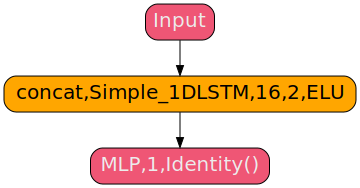

In [100]:
import graphviz
from dragon.utils.plot_functions import draw_cell, load_archi, str_operations

def draw_graph(n_dag, m_dag, output_file, act="Identity()", name="Input"):
    G = graphviz.Digraph(output_file, format='pdf',
                            node_attr={'nodesep': '0.02', 'shape': 'box', 'rankstep': '0.02', 'fontsize': '20', "fontname": "sans-serif"})

    G, g_nodes = draw_cell(G, n_dag, m_dag, "#ffa600", [], name_input=name,
                            color_input="#ef5675")
    G.node(','.join(["MLP", "1", act]), style="rounded,filled", color="black", fillcolor="#ef5675", fontcolor="#ECECEC")
    G.edge(g_nodes[-1], ','.join(["MLP", "1", act]))
    return G

best_model = load_archi("save/test_ts/best_model/x.pkl")
labels = [e.label for e in search_space]
best_model = dict(zip(labels, best_model))
m_dag = best_model['1D Dag'].matrix
n_dag = str_operations(best_model["1D Dag"].operations)

graph = draw_graph(n_dag, m_dag, "save/test_ts/best_archi")
print(f'Model giving a loss of ', search_algorithm.min_loss)
graph

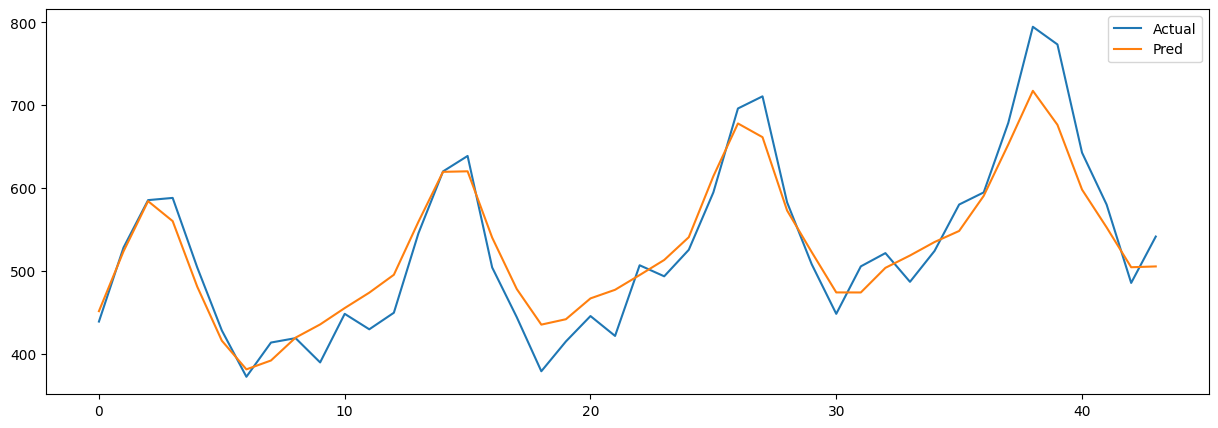

In [102]:
forecast = pd.read_csv("save/test_ts/best_model/best_model_forecasts_outputs.csv")
forecast[['Actual', 'Pred']].plot()
plt.legend()
plt.show()